In [6]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
from numba import cuda, jit, int32, int64
from math import ceil
from time import time

Алгоритм на CPU

In [7]:
def bilateral_cpu(img, blur, diameter):
  result_image = np.zeros(img.shape)
    
  for x in range(diameter, img.shape[0] - diameter):
    for y in range(diameter, img.shape[1] - diameter):
      sum = 0
      count = 0
      for i in range(x-diameter, x+diameter):
        for j in range(y-diameter, y+diameter):
          if abs(img[x][y]-img[i][j]) < blur:
            sum += img[i][j]
            count+=1
          
      result = sum / count
      result_image[x][y] = int(result)

  for x in range(diameter):
    for h in range(len(img)):
      result_image[h][x] = img[h][x]
      result_image[h][-x-1] = img[h][-x-1]
    for w in range(len(img[0])):
      result_image[x][w] = img[x][w]
      result_image[-x-1][w] = img[-x-1][w]

  return result_image

Алгоритм на GPU

In [8]:
@cuda.jit
def bilateral_gpu_cuda(img, result, blur_diameter):
  blur = blur_diameter[0]
  diameter = blur_diameter[1]
  idx = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
  jdx = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
  if idx < (img.shape[0])-(diameter*2) and (jdx < (img.shape[1])-(diameter*2)):
    x = idx + diameter
    y = jdx + diameter
    sum = 0
    count = 0
    for i in range(x-diameter, x+diameter):
      for j in range(y-diameter, y+diameter): 
        if abs(img[x][y] - img[i][j]) < blur:
          sum +=img[i][j]
          count+=1
    result[x][y] = int(sum / count)

Метод выполняющий GPU вычисления, пересылает даннные, запускает GPU исполнение

In [9]:
def bilateral_gpu(img, blur, diameter):
  result_image = np.zeros(img.shape)
  
  blur_diameter = [blur, diameter]

  dev_img = cuda.to_device(img)
  dev_result = cuda.to_device(result_image)
  dev_blur_diameter = cuda.to_device(blur_diameter)

  block = (32, 32)
  blockgrid = (ceil(img.shape[0]/block[0]), ceil(img.shape[1]/block[1]))

  bilateral_gpu_cuda[blockgrid, block](dev_img, dev_result, dev_blur_diameter)

  result = dev_result.copy_to_host()
  
  for x in range(diameter):
    for h in range(len(img)):
      result[h][x] = img[h][x]
      result[h][-x-1] = img[h][-x-1]
    for w in range(len(img[0])):
      result[x][w] = img[x][w]
      result[-x-1][w] = img[-x-1][w]
  
  return result

Тесты

Number of Pixels: 65536
Shape/Dimensions: (256, 256)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in ubyte_scalars
  # Remove the CWD from sys.path while we load stuff.


Result CPU for blur =  1  and diameter =  1
CPU time : 0.8925542831420898
CPU: picture


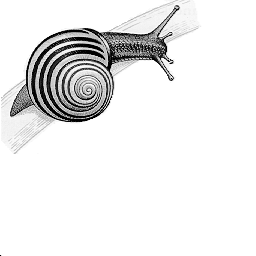

/usr/local/lib/python3.7/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 64 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Result GPU for blur =  1  and diameter =  1
GPU time : 1.2340779304504395
GPU: picture


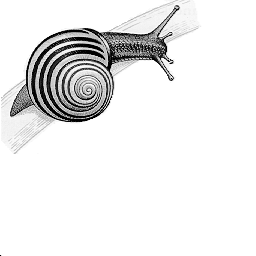

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in ubyte_scalars
  # Remove the CWD from sys.path while we load stuff.


Result CPU for blur =  1  and diameter =  2
CPU time : 2.748795747756958
CPU: picture


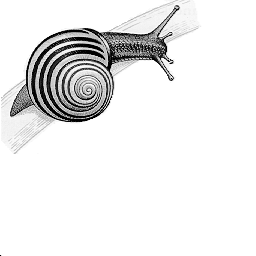

Result GPU for blur =  1  and diameter =  2
GPU time : 0.017052173614501953
GPU: picture


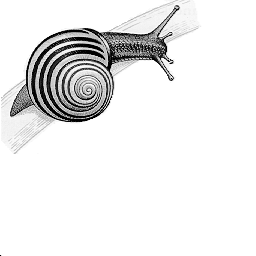


Result CPU for blur =  1  and diameter =  3
CPU time : 5.699605941772461
CPU: picture


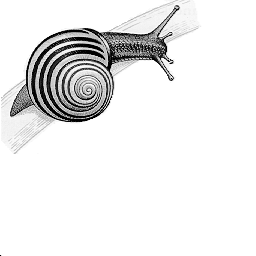

Result GPU for blur =  1  and diameter =  3
GPU time : 0.008122682571411133
GPU: picture


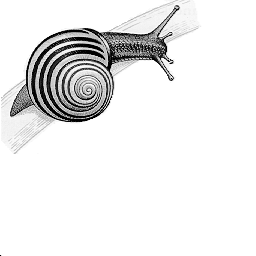


Result CPU for blur =  51  and diameter =  1
CPU time : 0.8671162128448486
CPU: picture


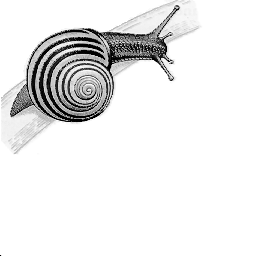

Result GPU for blur =  51  and diameter =  1
GPU time : 0.009356021881103516
GPU: picture


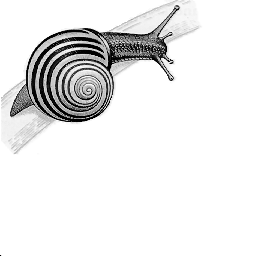


Result CPU for blur =  51  and diameter =  2
CPU time : 2.8316092491149902
CPU: picture


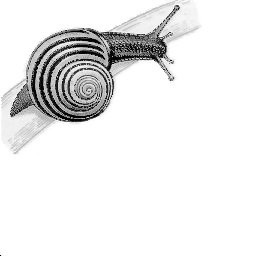

Result GPU for blur =  51  and diameter =  2
GPU time : 0.007858753204345703
GPU: picture


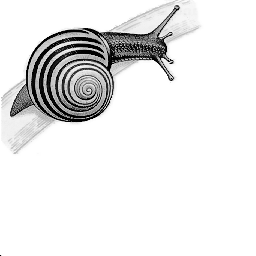


Result CPU for blur =  51  and diameter =  3
CPU time : 5.869359731674194
CPU: picture


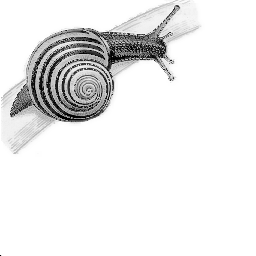

Result GPU for blur =  51  and diameter =  3
GPU time : 0.005476236343383789
GPU: picture


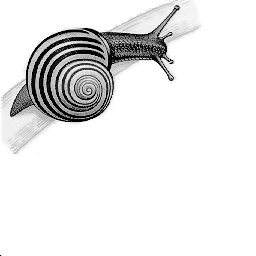


Result CPU for blur =  101  and diameter =  1
CPU time : 0.8662533760070801
CPU: picture


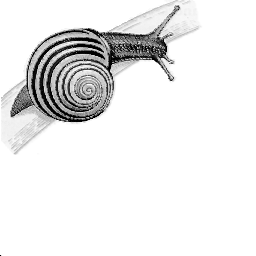

Result GPU for blur =  101  and diameter =  1
GPU time : 0.007512807846069336
GPU: picture


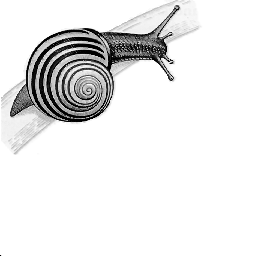


Result CPU for blur =  101  and diameter =  2
CPU time : 2.7806239128112793
CPU: picture


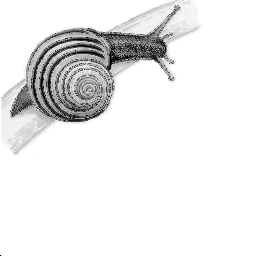

Result GPU for blur =  101  and diameter =  2
GPU time : 0.010755300521850586
GPU: picture


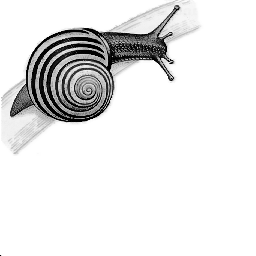


Result CPU for blur =  101  and diameter =  3
CPU time : 5.872507572174072
CPU: picture


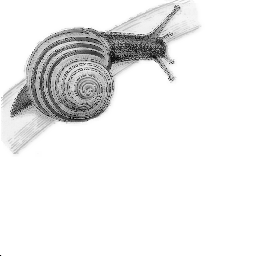

Result GPU for blur =  101  and diameter =  3
GPU time : 0.011447429656982422
GPU: picture


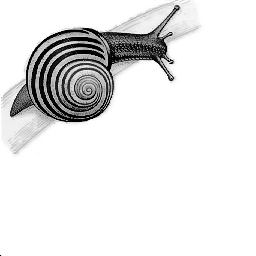


Result CPU for blur =  151  and diameter =  1
CPU time : 0.9119081497192383
CPU: picture


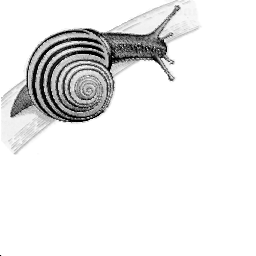

Result GPU for blur =  151  and diameter =  1
GPU time : 0.009432554244995117
GPU: picture


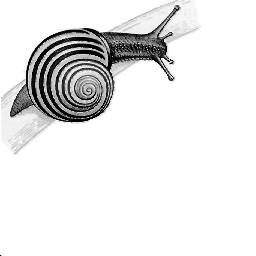


Result CPU for blur =  151  and diameter =  2
CPU time : 2.8028857707977295
CPU: picture


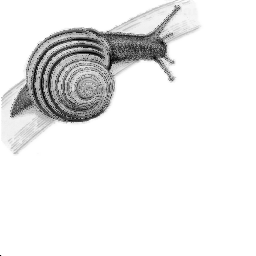

Result GPU for blur =  151  and diameter =  2
GPU time : 0.009055614471435547
GPU: picture


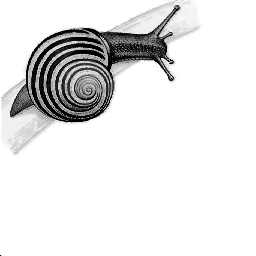


Result CPU for blur =  151  and diameter =  3
CPU time : 5.6948628425598145
CPU: picture


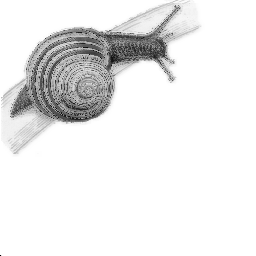

Result GPU for blur =  151  and diameter =  3
GPU time : 0.007884740829467773
GPU: picture


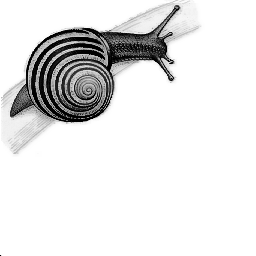


Result CPU for blur =  201  and diameter =  1
CPU time : 0.854835033416748
CPU: picture


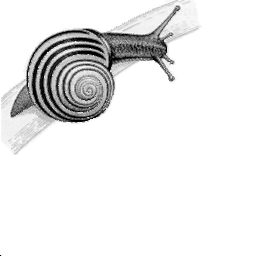

Result GPU for blur =  201  and diameter =  1
GPU time : 0.009749412536621094
GPU: picture


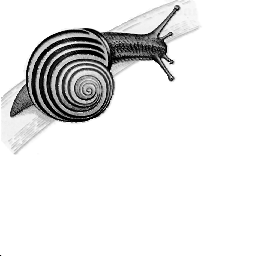


Result CPU for blur =  201  and diameter =  2
CPU time : 2.9090709686279297
CPU: picture


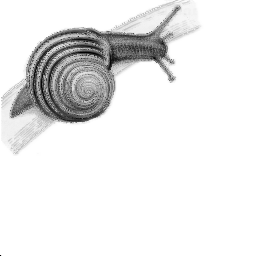

Result GPU for blur =  201  and diameter =  2
GPU time : 0.004670858383178711
GPU: picture


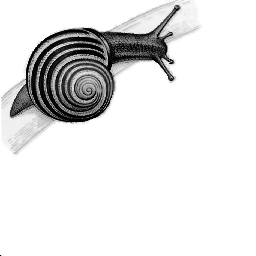


Result CPU for blur =  201  and diameter =  3
CPU time : 5.904309034347534
CPU: picture


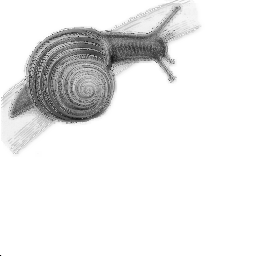

Result GPU for blur =  201  and diameter =  3
GPU time : 0.009696483612060547
GPU: picture


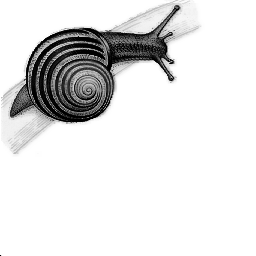


Result CPU for blur =  251  and diameter =  1
CPU time : 0.9015810489654541
CPU: picture


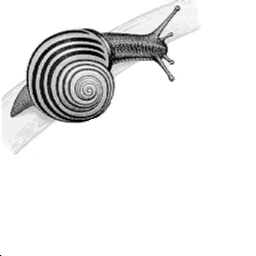

Result GPU for blur =  251  and diameter =  1
GPU time : 0.003718137741088867
GPU: picture


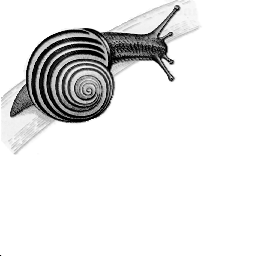


Result CPU for blur =  251  and diameter =  2
CPU time : 2.8119468688964844
CPU: picture


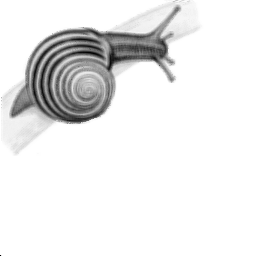

Result GPU for blur =  251  and diameter =  2
GPU time : 0.004660606384277344
GPU: picture


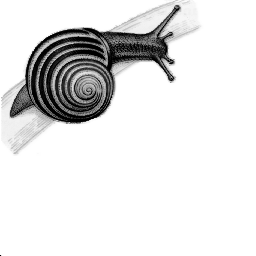


Result CPU for blur =  251  and diameter =  3
CPU time : 5.829537630081177
CPU: picture


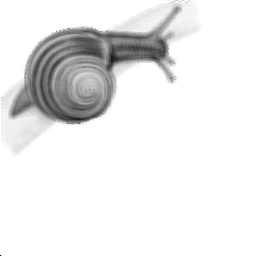

Result GPU for blur =  251  and diameter =  3
GPU time : 0.00858306884765625
GPU: picture


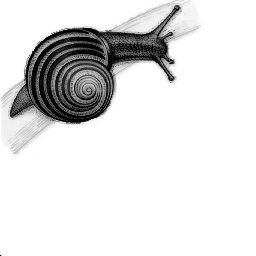

In [10]:
img = cv2.imread('snail.bmp', cv2.IMREAD_GRAYSCALE)
print("Number of Pixels: " + str(img.size))
print("Shape/Dimensions: " + str(img.shape))

for blur in range (1, 255, 50):
  for diameter in range (1, 4):
    startCPU = time()
    cpu = np.array(bilateral_cpu(img, blur, diameter))
    print("Result CPU for blur = ", blur, " and diameter = ", diameter)
    print("CPU time :", time()-startCPU)
    print("CPU: picture")
    cv2_imshow(cpu)

    startGPU = time()
    gpu = bilateral_gpu(img, blur, diameter)
    print("Result GPU for blur = ", blur, " and diameter = ", diameter)
    print("GPU time :", time()-startGPU)
    print("GPU: picture")
    cv2_imshow(gpu)
    print()